# AMEDA - Angular Momentum Eddy Detection Algorithm
## Visualization and Analysis Notebook

This notebook demonstrates the Python implementation of AMEDA for detecting ocean eddies.

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.patches import Circle
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import warnings
warnings.filterwarnings('ignore')



In [2]:
# Import AMEDA modules
from osl.ameda.fields import compute_fields
from osl.ameda.load_fields import load_fields
from osl.ameda.params import AMEDAParams, derive_params


print("AMEDA modules loaded successfully!")

AMEDA modules loaded successfully!


## 1. Load and Explore Data

In [3]:
# Dataset path
DATASET = "/Users/gianlucacalo/Desktop/projects/ocean_surface_levels/data/raw/cmems_obs-sl_eur_phy-ssh_my_allsat-l4-duacs-0.0625deg_P1D.nc"

# Load dataset
ds = xr.open_dataset(DATASET)

# Display dataset info
print("Dataset Information:")
print(f"Time range: {ds.time.values[0]} to {ds.time.values[-1]}")
print(f"Spatial extent: Lon [{ds.longitude.min().values:.1f}, {ds.longitude.max().values:.1f}]")
print(f"                Lat [{ds.latitude.min().values:.1f}, {ds.latitude.max().values:.1f}]")
print(f"Variables: {list(ds.data_vars.keys())}")
print(f"Grid resolution: {ds.longitude.values[1] - ds.longitude.values[0]:.4f}°")

Dataset Information:
Time range: 1993-01-01T00:00:00.000000000 to 2024-06-13T00:00:00.000000000
Spatial extent: Lon [-30.0, -10.0]
                Lat [22.0, 29.5]
Variables: ['sla', 'ugos', 'vgos']
Grid resolution: 0.0625°


## 2. Configure AMEDA Parameters

In [4]:
# Configure parameters
params = AMEDAParams(
    x_name="longitude",
    y_name="latitude",
    u_name="ugos",
    v_name="vgos",
    s_name="sla",
    type_detection=3,  # Use both velocity and SSH
    K=0.7,  # LNAM threshold
    nRmin=0.3,  # Minimum eddy size
    nR_lim=200,  # Maximum eddy size
    n_min=4,  # Minimum points for contour
    DH=0.001,  # SSH spacing for streamlines
    nH_lim=50,  # Maximum number of streamlines
    lat_min=5  # Minimum latitude for detection
)

print("AMEDA Parameters:")
print(f"  Detection type: {'Velocity + SSH' if params.type_detection == 3 else 'Velocity only'}")
print(f"  LNAM threshold (K): {params.K}")
print(f"  Min latitude: {params.lat_min}°")
print(f"  Resolution factor: {params.resol}")

AMEDA Parameters:
  Detection type: Velocity + SSH
  LNAM threshold (K): 0.7
  Min latitude: 5°
  Resolution factor: 1


## 3. Select Time Step and Compute Derived Parameters

In [5]:
# Select time step
step = 0  # First time step
data_step = ds.isel(time=step)


# Compute derived parameters
params = derive_params(ds, step, params) # using step 0 to derive parameters

print(f"Processing time: {data_step.time.values}")
print("\nDerived parameters computed:")
print(f"  Rossby radius range: {np.nanmin(params.Rd):.1f} - {np.nanmax(params.Rd):.1f} km")
print(f"  Grid spacing: {np.nanmean(params.Dx):.1f} km")
print(f"  LNAM box size: {np.nanmin(params.b):.0f} - {np.nanmax(params.b):.0f} pixels")

Processing time: 1993-01-01T00:00:00.000000000

Derived parameters computed:
  Rossby radius range: 22.2 - 55.0 km
  Grid spacing: 6.6 km
  LNAM box size: 2 - 4 pixels


## 4. Visualize Input Fields

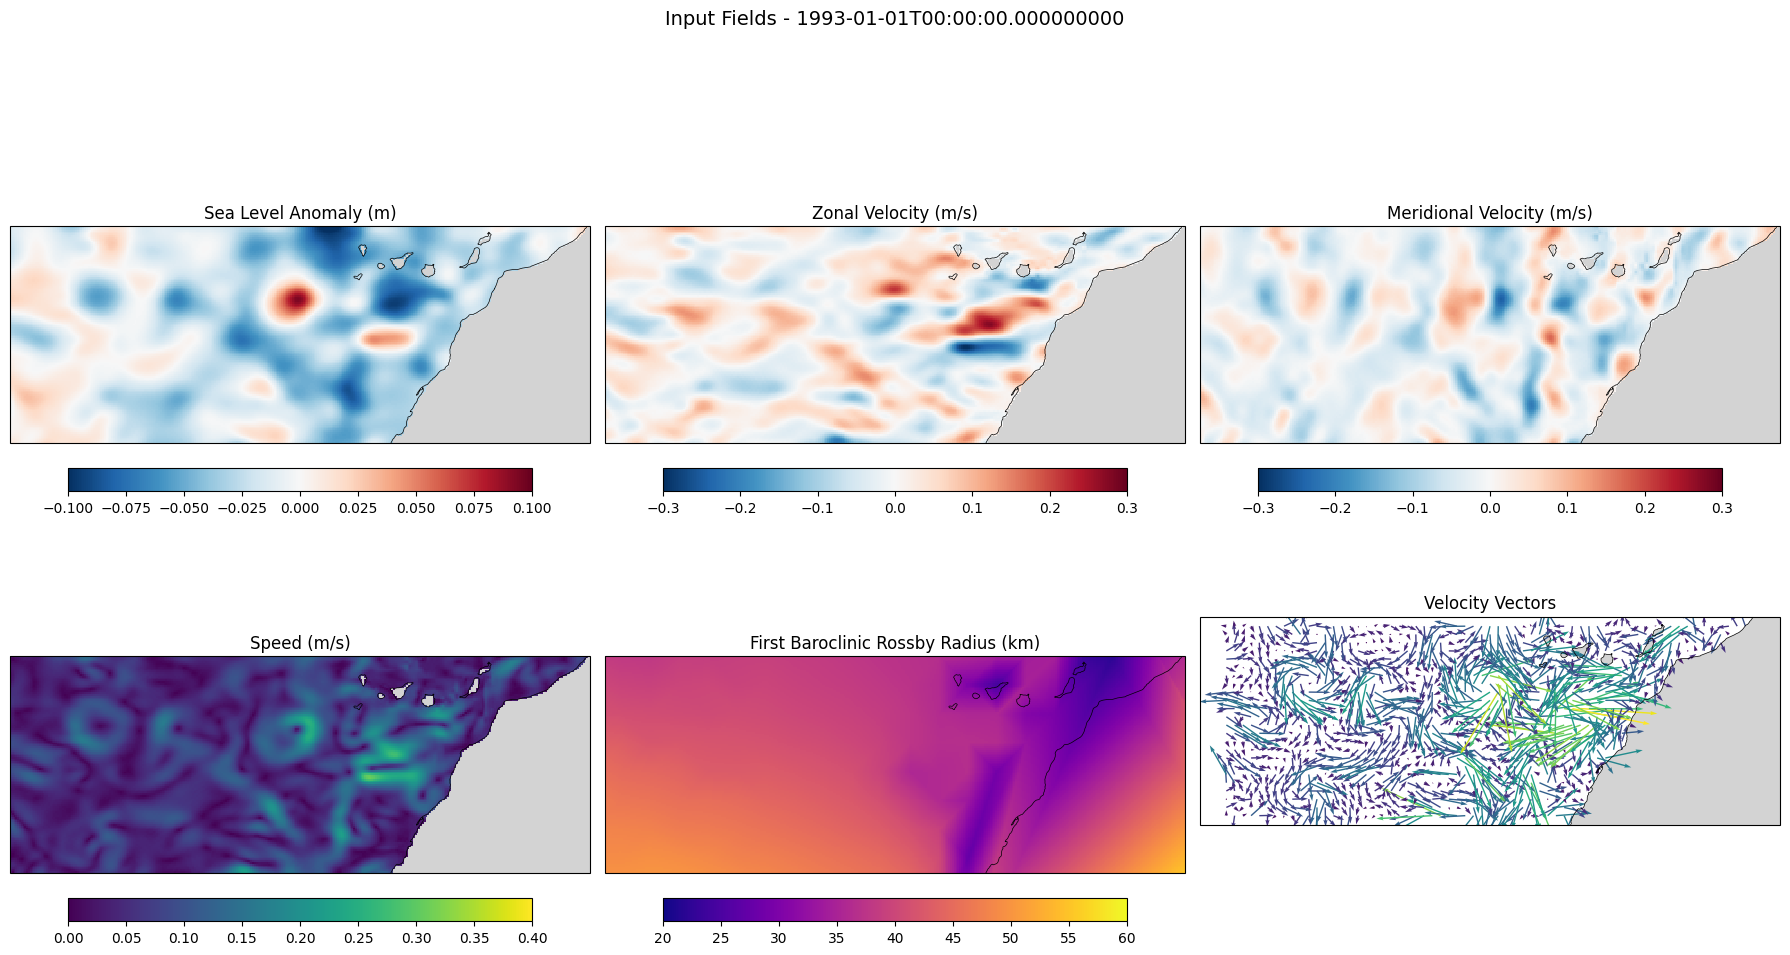

In [6]:

lon = data_step.longitude.values
lat = data_step.latitude.values
ugos = data_step.ugos.values
vgos = data_step.vgos.values
sla = data_step.sla.values
mask = ~np.isnan(ugos)


# Create figure with input fields
fig = plt.figure(figsize=(18, 10))

# Create meshgrid
lon_grid, lat_grid = np.meshgrid(lon, lat)

# 1. Sea Level Anomaly
ax1 = fig.add_subplot(2, 3, 1, projection=ccrs.PlateCarree())
im1 = ax1.pcolormesh(lon_grid, lat_grid, sla, 
                     cmap='RdBu_r', vmin=-0.1, vmax=0.1,
                     transform=ccrs.PlateCarree())
ax1.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax1.add_feature(cfeature.LAND, facecolor='lightgray')
ax1.set_title('Sea Level Anomaly (m)')
plt.colorbar(im1, ax=ax1, orientation='horizontal', pad=0.05, shrink=0.8)

# 2. Zonal velocity (u)
ax2 = fig.add_subplot(2, 3, 2, projection=ccrs.PlateCarree())
im2 = ax2.pcolormesh(lon_grid, lat_grid, ugos,
                     cmap='RdBu_r', vmin=-0.3, vmax=0.3,
                     transform=ccrs.PlateCarree())
ax2.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax2.add_feature(cfeature.LAND, facecolor='lightgray')
ax2.set_title('Zonal Velocity (m/s)')
plt.colorbar(im2, ax=ax2, orientation='horizontal', pad=0.05, shrink=0.8)

# 3. Meridional velocity (v)
ax3 = fig.add_subplot(2, 3, 3, projection=ccrs.PlateCarree())
im3 = ax3.pcolormesh(lon_grid, lat_grid, vgos,
                     cmap='RdBu_r', vmin=-0.3, vmax=0.3,
                     transform=ccrs.PlateCarree())
ax3.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax3.add_feature(cfeature.LAND, facecolor='lightgray')
ax3.set_title('Meridional Velocity (m/s)')
plt.colorbar(im3, ax=ax3, orientation='horizontal', pad=0.05, shrink=0.8)

# 4. Velocity magnitude
speed = np.sqrt(ugos**2 + vgos**2)
ax4 = fig.add_subplot(2, 3, 4, projection=ccrs.PlateCarree())
im4 = ax4.pcolormesh(lon_grid, lat_grid, speed,
                     cmap='viridis', vmin=0, vmax=0.4,
                     transform=ccrs.PlateCarree())
ax4.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax4.add_feature(cfeature.LAND, facecolor='lightgray')
ax4.set_title('Speed (m/s)')
plt.colorbar(im4, ax=ax4, orientation='horizontal', pad=0.05, shrink=0.8)

# 5. Rossby radius
ax5 = fig.add_subplot(2, 3, 5, projection=ccrs.PlateCarree())
im5 = ax5.pcolormesh(lon_grid, lat_grid, params.Rd,
                     cmap='plasma', vmin=20, vmax=60,
                     transform=ccrs.PlateCarree())
ax5.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax5.add_feature(cfeature.LAND, facecolor='lightgray')
ax5.set_title('First Baroclinic Rossby Radius (km)')
plt.colorbar(im5, ax=ax5, orientation='horizontal', pad=0.05, shrink=0.8)

# 6. Velocity vectors (subsampled)
ax6 = fig.add_subplot(2, 3, 6, projection=ccrs.PlateCarree())
skip = 5  # Subsample for clarity
ax6.quiver(lon_grid[::skip, ::skip], lat_grid[::skip, ::skip],
           ugos[::skip, ::skip], vgos[::skip, ::skip],
           speed[::skip, ::skip], cmap='viridis', scale=2,
           transform=ccrs.PlateCarree())
ax6.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax6.add_feature(cfeature.LAND, facecolor='lightgray')
ax6.set_title('Velocity Vectors')

plt.suptitle(f'Input Fields - {data_step.time.values}', fontsize=14, y=0.98)
plt.tight_layout()
plt.show()

## 5. Compute Detection Fields

In [7]:
# Compute detection fields
print("Computing detection fields...")

# Load fields for grid
x, y, mask_field, u, v, ssh = load_fields(ds, step, params)

fields = compute_fields(x, y, mask_field, u, v, step, params)

print("\nField statistics:")
print(f"  Kinetic Energy: {np.nanmin(fields.ke):.6f} - {np.nanmax(fields.ke):.6f} m²/s²")
print(f"  Vorticity: {np.nanmin(fields.vort):.2e} - {np.nanmax(fields.vort):.2e} s⁻¹")
print(f"  Okubo-Weiss: {np.nanmin(fields.OW):.2e} - {np.nanmax(fields.OW):.2e} s⁻²")
print(f"  Local OW: {np.nanmin(fields.LOW):.2e} - {np.nanmax(fields.LOW):.2e} s⁻²")
print(f"  LNAM: {np.nanmin(fields.LNAM):.3f} - {np.nanmax(fields.LNAM):.3f}")

Computing detection fields...
Loading fields at step 0...
NO INTERPOLATION
Enlarging coastal mask by 1 pixel...
Computing fields for step 0
Computing LNAM...

Field statistics:
  Kinetic Energy: 0.000000 - 0.047554 m²/s²
  Vorticity: -1.89e-05 - 1.38e-05 s⁻¹
  Okubo-Weiss: -3.04e-10 - 1.45e-10 s⁻²
  Local OW: -1.60e-10 - 9.32e-11 s⁻²
  LNAM: -1.520 - 1.511


## 6. Visualize Detection Fields

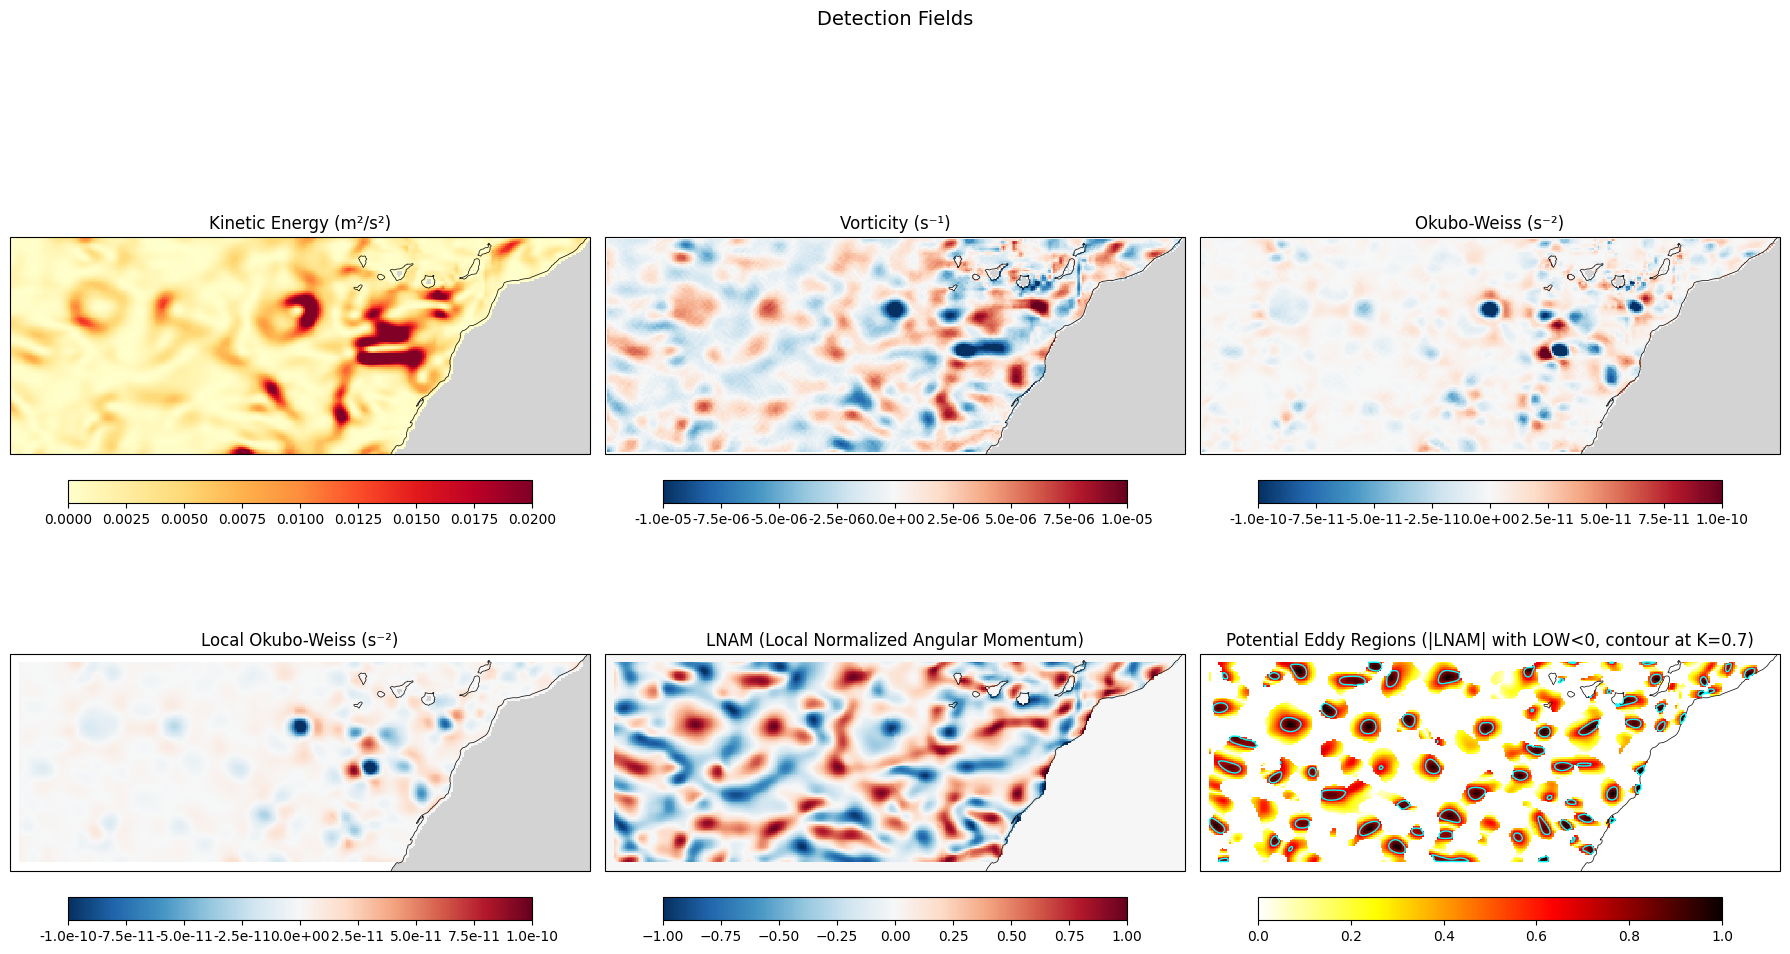

In [8]:
# Create figure with detection fields
fig = plt.figure(figsize=(18, 10))

# 1. Kinetic Energy
ax1 = fig.add_subplot(2, 3, 1, projection=ccrs.PlateCarree())
im1 = ax1.pcolormesh(x, y, fields.ke,
                     cmap='YlOrRd', vmin=0, vmax=0.02,
                     transform=ccrs.PlateCarree())
ax1.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax1.add_feature(cfeature.LAND, facecolor='lightgray')
ax1.set_title('Kinetic Energy (m²/s²)')
plt.colorbar(im1, ax=ax1, orientation='horizontal', pad=0.05, shrink=0.8)

# 2. Vorticity
ax2 = fig.add_subplot(2, 3, 2, projection=ccrs.PlateCarree())
vort_lim = 1e-5
im2 = ax2.pcolormesh(x, y, fields.vort,
                     cmap='RdBu_r', vmin=-vort_lim, vmax=vort_lim,
                     transform=ccrs.PlateCarree())
ax2.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax2.add_feature(cfeature.LAND, facecolor='lightgray')
ax2.set_title('Vorticity (s⁻¹)')
plt.colorbar(im2, ax=ax2, orientation='horizontal', pad=0.05, shrink=0.8, format='%.1e')

# 3. Okubo-Weiss
ax3 = fig.add_subplot(2, 3, 3, projection=ccrs.PlateCarree())
ow_lim = 1e-10
im3 = ax3.pcolormesh(x, y, fields.OW,
                     cmap='RdBu_r', vmin=-ow_lim, vmax=ow_lim,
                     transform=ccrs.PlateCarree())
ax3.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax3.add_feature(cfeature.LAND, facecolor='lightgray')
ax3.set_title('Okubo-Weiss (s⁻²)')
plt.colorbar(im3, ax=ax3, orientation='horizontal', pad=0.05, shrink=0.8, format='%.1e')

# 4. Local Okubo-Weiss
ax4 = fig.add_subplot(2, 3, 4, projection=ccrs.PlateCarree())
im4 = ax4.pcolormesh(x, y, fields.LOW,
                     cmap='RdBu_r', vmin=-ow_lim, vmax=ow_lim,
                     transform=ccrs.PlateCarree())
ax4.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax4.add_feature(cfeature.LAND, facecolor='lightgray')
ax4.set_title('Local Okubo-Weiss (s⁻²)')
plt.colorbar(im4, ax=ax4, orientation='horizontal', pad=0.05, shrink=0.8, format='%.1e')

# 5. LNAM
ax5 = fig.add_subplot(2, 3, 5, projection=ccrs.PlateCarree())
im5 = ax5.pcolormesh(x, y, fields.LNAM,
                     cmap='RdBu_r', vmin=-1, vmax=1,
                     transform=ccrs.PlateCarree())
ax5.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax5.add_feature(cfeature.LAND, facecolor='lightgray')
ax5.set_title('LNAM (Local Normalized Angular Momentum)')
plt.colorbar(im5, ax=ax5, orientation='horizontal', pad=0.05, shrink=0.8)

# 6. Potential eddy regions
ax6 = fig.add_subplot(2, 3, 6, projection=ccrs.PlateCarree())
potential = np.abs(fields.LNAM) * (fields.LOW < 0)
im6 = ax6.pcolormesh(x, y, potential,
                     cmap='hot_r', vmin=0, vmax=1,
                     transform=ccrs.PlateCarree())
ax6.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax6.add_feature(cfeature.LAND, facecolor='lightgray')
ax6.contour(x, y, potential, levels=[params.K], colors='cyan', linewidths=1)
ax6.set_title(f'Potential Eddy Regions (|LNAM| with LOW<0, contour at K={params.K})')
plt.colorbar(im6, ax=ax6, orientation='horizontal', pad=0.05, shrink=0.8)

plt.suptitle('Detection Fields', fontsize=14, y=0.98)
plt.tight_layout()
plt.show()

## 7. Detect Eddy Centers

In [9]:
# Simple center detection (without full streamline validation for speed)
print("Detecting eddy centers...")

# Find LNAM maxima where LOW < 0
LOW = fields.LOW
LNAM = fields.LNAM
abs_lnam = np.abs(LNAM)

# Apply thresholds
candidates = (abs_lnam > params.K) & (LOW < 0) & (mask_field > 0)

# Apply latitude constraint if using geographic coordinates
if params.grid_ll and params.lat_min > 0:
    candidates = candidates & (np.abs(y) > params.lat_min)

# Find local maxima
from scipy.ndimage import maximum_filter
local_max = (abs_lnam == maximum_filter(abs_lnam, size=3)) & candidates

# Get center coordinates
j_idx, i_idx = np.where(local_max)
n_centers = len(j_idx)

print(f"\nFound {n_centers} potential eddy centers")

# Classify eddies
cyclonic = []
anticyclonic = []

for k in range(n_centers):
    center_type = np.sign(LNAM[j_idx[k], i_idx[k]])
    center_info = {
        'lon': x[j_idx[k], i_idx[k]],
        'lat': y[j_idx[k], i_idx[k]],
        'lnam': LNAM[j_idx[k], i_idx[k]],
        'i': i_idx[k],
        'j': j_idx[k]
    }
    
    if center_type > 0:
        cyclonic.append(center_info)
    else:
        anticyclonic.append(center_info)

print(f"  Cyclonic eddies: {len(cyclonic)}")
print(f"  Anticyclonic eddies: {len(anticyclonic)}")

# Show first few centers
print("\nFirst 5 cyclonic centers:")
for i, c in enumerate(cyclonic[:5]):
    print(f"  {i+1}. Lon: {c['lon']:.3f}°, Lat: {c['lat']:.3f}°, LNAM: {c['lnam']:.3f}")

print("\nFirst 5 anticyclonic centers:")
for i, c in enumerate(anticyclonic[:5]):
    print(f"  {i+1}. Lon: {c['lon']:.3f}°, Lat: {c['lat']:.3f}°, LNAM: {c['lnam']:.3f}")

Detecting eddy centers...

Found 77 potential eddy centers
  Cyclonic eddies: 38
  Anticyclonic eddies: 39

First 5 cyclonic centers:
  1. Lon: -29.219°, Lat: 22.344°, LNAM: 0.889
  2. Lon: -18.156°, Lat: 22.406°, LNAM: 0.960
  3. Lon: -16.594°, Lat: 22.781°, LNAM: 0.898
  4. Lon: -27.469°, Lat: 23.031°, LNAM: 0.911
  5. Lon: -21.531°, Lat: 23.281°, LNAM: 0.827

First 5 anticyclonic centers:
  1. Lon: -21.656°, Lat: 22.344°, LNAM: -0.844
  2. Lon: -21.031°, Lat: 22.344°, LNAM: -0.850
  3. Lon: -26.906°, Lat: 22.781°, LNAM: -0.720
  4. Lon: -23.219°, Lat: 22.844°, LNAM: -0.994
  5. Lon: -17.219°, Lat: 23.031°, LNAM: -0.759


## 8. Visualize Detected Eddies

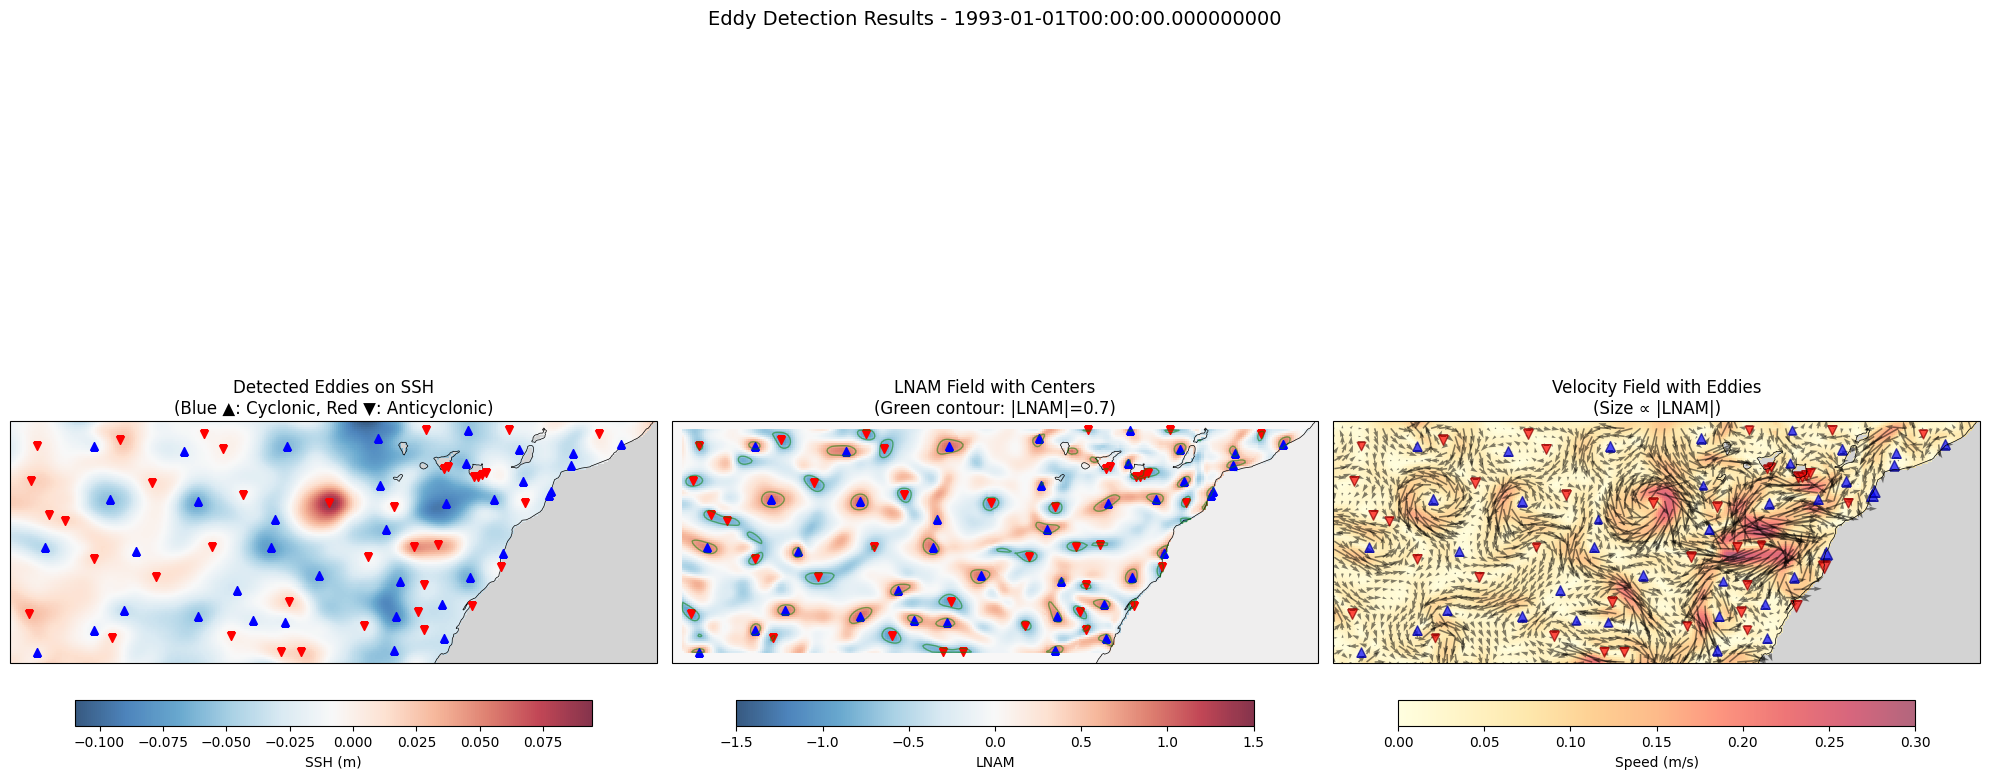


Eddy Statistics:
Total eddies detected: 77
  Cyclonic: 38 (49.4%)
  Anticyclonic: 39 (50.6%)

Cyclonic LNAM: 0.945 ± 0.154
  Range: [0.705, 1.511]

Anticyclonic LNAM: 0.912 ± 0.152
  Range: [0.715, 1.520]


In [10]:
# Create comprehensive eddy visualization
fig = plt.figure(figsize=(20, 8))

# 1. Eddies on SSH field
ax1 = fig.add_subplot(1, 3, 1, projection=ccrs.PlateCarree())
im1 = ax1.pcolormesh(lon_grid, lat_grid, sla,
                     cmap='RdBu_r',
                     transform=ccrs.PlateCarree(), alpha=0.8)

# Plot eddy centers
for c in cyclonic:
    ax1.plot(c['lon'], c['lat'], 'b^', markersize=6, transform=ccrs.PlateCarree())
for c in anticyclonic:
    ax1.plot(c['lon'], c['lat'], 'rv', markersize=6, transform=ccrs.PlateCarree())

ax1.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax1.add_feature(cfeature.LAND, facecolor='lightgray')
ax1.set_title('Detected Eddies on SSH\n(Blue ▲: Cyclonic, Red ▼: Anticyclonic)')
plt.colorbar(im1, ax=ax1, orientation='horizontal', pad=0.05, shrink=0.8, label='SSH (m)')

# 2. Eddies on LNAM field
ax2 = fig.add_subplot(1, 3, 2, projection=ccrs.PlateCarree())
im2 = ax2.pcolormesh(x, y, fields.LNAM,
                     cmap='RdBu_r', vmin=-1.5, vmax=1.5,
                     transform=ccrs.PlateCarree(), alpha=0.8)

# Plot eddy centers
for c in cyclonic:
    ax2.plot(c['lon'], c['lat'], 'b^', markersize=6, transform=ccrs.PlateCarree())
for c in anticyclonic:
    ax2.plot(c['lon'], c['lat'], 'rv', markersize=6, transform=ccrs.PlateCarree())

# Add LNAM threshold contours
ax2.contour(x, y, np.abs(fields.LNAM), levels=[params.K], colors='green', linewidths=1, alpha=0.5)

ax2.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax2.add_feature(cfeature.LAND, facecolor='lightgray')
ax2.set_title(f'LNAM Field with Centers\n(Green contour: |LNAM|={params.K})')
plt.colorbar(im2, ax=ax2, orientation='horizontal', pad=0.05, shrink=0.8, label='LNAM')

# 3. Eddies on velocity field
ax3 = fig.add_subplot(1, 3, 3, projection=ccrs.PlateCarree())

# Velocity magnitude background
speed = np.sqrt(ugos**2 + vgos**2)
im3 = ax3.pcolormesh(lon_grid, lat_grid, speed,
                     cmap='YlOrRd', vmin=0, vmax=0.3,
                     transform=ccrs.PlateCarree(), alpha=0.6)

# Velocity vectors
skip = 4
ax3.quiver(lon_grid[::skip, ::skip], lat_grid[::skip, ::skip],
           ugos[::skip, ::skip], vgos[::skip, ::skip],
           scale=3, alpha=0.5, transform=ccrs.PlateCarree())

# Plot eddy centers with size proportional to |LNAM|
for c in cyclonic:
    size = np.abs(c['lnam']) * 50
    ax3.scatter(c['lon'], c['lat'], s=size, c='blue', marker='^', 
               edgecolors='darkblue', alpha=0.7, transform=ccrs.PlateCarree())
for c in anticyclonic:
    size = np.abs(c['lnam']) * 50
    ax3.scatter(c['lon'], c['lat'], s=size, c='red', marker='v',
               edgecolors='darkred', alpha=0.7, transform=ccrs.PlateCarree())

ax3.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax3.add_feature(cfeature.LAND, facecolor='lightgray')
ax3.set_title('Velocity Field with Eddies\n(Size ∝ |LNAM|)')
plt.colorbar(im3, ax=ax3, orientation='horizontal', pad=0.05, shrink=0.8, label='Speed (m/s)')

plt.suptitle(f'Eddy Detection Results - {data_step.time.values}', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# Summary statistics
print("\nEddy Statistics:")
print(f"Total eddies detected: {n_centers}")
print(f"  Cyclonic: {len(cyclonic)} ({len(cyclonic)/n_centers*100:.1f}%)")
print(f"  Anticyclonic: {len(anticyclonic)} ({len(anticyclonic)/n_centers*100:.1f}%)")

if cyclonic:
    cyc_lnam = [abs(c['lnam']) for c in cyclonic]
    print(f"\nCyclonic LNAM: {np.mean(cyc_lnam):.3f} ± {np.std(cyc_lnam):.3f}")
    print(f"  Range: [{np.min(cyc_lnam):.3f}, {np.max(cyc_lnam):.3f}]")

if anticyclonic:
    anti_lnam = [abs(c['lnam']) for c in anticyclonic]
    print(f"\nAnticyclonic LNAM: {np.mean(anti_lnam):.3f} ± {np.std(anti_lnam):.3f}")
    print(f"  Range: [{np.min(anti_lnam):.3f}, {np.max(anti_lnam):.3f}]")